In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
directory = os.path.join("..", "data") 


# Load Parcel Data

In [2]:
# names = ["event_id", "user_id", "location_id", "lon", "lat", "epoch_time", "day_id", "seconds_since_monday"]
# data = pd.read_csv(os.path.join(directory, "parcel_ass-oc-ass_events_no_filter.csv"), header = None, names = names)
# data.sort_values(['user_id', 'epoch_time'], inplace=True)
# data.describe()

# Visits  

Moshe created visits by _replac[ing] tweets
occurring with the same hour and within 50 meters of each
other with a single effective tweet._ 

Note that the `epoch_time` column contains timestamps (not sure the timezone) with a milisecond resolution. We will use that column to create visits in a similar fashion that also incorporates the location of the tweet.

In [3]:
d = 0.05  # 50 m
t = 60**2  # number of s in one hr

def spherical_dist(pos1, r=6371):
    """
    return distance matrix in km
    
    https://stackoverflow.com/questions/19413259/efficient-way-to-calculate-distance-matrix-given-latitude-and-longitude-data-in
    """
    pos2 = np.array(pos1)
    pos1 = np.array(pos1)[:, None]
    pos1 = np.deg2rad(pos1)
    pos2 = np.deg2rad(pos2)
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

def temporal_dist(times):
    """matrix of time differences"""
    times = np.array(times)
    return np.abs(np.subtract.outer(times, times))

def invert_dict(d): 
    """reverse a dictionary with list/set values"""
    inverse = dict() 
    for key in d: 
        for item in d[key]:
            inverse[item] = key
    return inverse

def set_visits(df):
    """
    :param df: pd.DataFrame for one user with <lat, lon, epoch_time> columns
    :return: same pd.DataFrame with a visit column containing integer visit id
    """
    # find groups of points that meet both the dist and time criteria for a visit
    distance_match = spherical_dist(df[['lat', 'lon']]) <= d
    time_match = temporal_dist(df['epoch_time']) <= t
    matches = distance_match & time_match
    groups = {}
    i = 0
    for row_i, row in enumerate(matches):
        v = list([i for i, is_true in enumerate(row) if is_true])
        if v not in groups.values():
            groups[i] = v
            i += 1
    df['visit'] = invert_dict(groups).values()
    return df

### Apply to the entire data set & save result

In [4]:
# data = data.groupby('user_id').apply(set_visits)
# data.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_no_filter.csv"), index=False)

In [5]:
# RAW DATA COUNTS
data = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_no_filter.csv"))
print("Events:", data.shape[0])
print("Users:", data.user_id.nunique())
print("Avg:", data.shape[0] / data.user_id.nunique())

Events: 655917
Users: 103271
Avg: 6.351415208529016


In [6]:
# VISIT DATA COUNTS
data_deduped = data.drop_duplicates(['user_id', 'location_id', 'visit'])
print("Events:", data_deduped.shape[0])
print("Users:", data_deduped.user_id.nunique())
print("Avg:", data_deduped.shape[0] / data_deduped.user_id.nunique())

Events: 545697
Users: 103271
Avg: 5.284126230984497


In [7]:
# DURATION OF OBSERVATION
print("({min}, {max}) days".format(min=min(data.day_id), max=max(data.day_id)))

(1.0, 244.0) days


## Format & filter for analysis

In [8]:
def sequential_filter_data(df, time_span='month', n_k=30):
    """
    Filter to users with at least n_k events in 2 sequential time_spans
    
    df: pd.DataFrame containing {user_id, day_id } columns 
    time_span: str in {'week', 'month', 'bimonth'}
    n_k: number of events a user must have in each time_span
    """
    t_vals = {
        'week': 7,
        'month': 30,
        'bimonth': 60,
    }
    t = t_vals.get(time_span)
    if t is None:
        return print("Enter a valid time_span... {'week', 'month', 'bimonth'}")

    # reset day id to start at 0
    df["day_id"] = df["day_id"] - df["day_id"].min()
    
    # calculate time_used ids
    df[time_span] = data.day_id // t
    
    # calc nevents in each time_span for each user & filter by min threshold
    counts = df.groupby(["user_id", time_span]).count()["event_id"]
    view = counts[counts >= n_k].reset_index()
    
    # join together to have a row for each user for a single time_span joined 
    # with the prior and next time_span
    lagged_view = pd.concat(
        [view, view.shift(1), view.shift(2)], 
        axis = 1
    )
    lagged_view.columns = list("next_" + view.columns) + \
        list(view.columns) + list("last_" + view.columns)
    
    # filter rows so that they only contain pairs where there is a sequential time_span present
    right_users = (lagged_view["user_id"] == lagged_view["next_user_id"]) | \
        (lagged_view["user_id"] == lagged_view["last_user_id"])
    sequential = ((lagged_view["next_"+time_span] - lagged_view[time_span]) == 1) | \
        ((lagged_view[time_span] - lagged_view["last_"+time_span]) == 1)
    filtered = lagged_view[right_users & sequential][["user_id", time_span, "event_id"]].reset_index(drop=True)
    
    # gather ids and valid weeks for the users that have survived the filtering
    user_time_dict = {-1 : []}
    for i, x in filtered.iterrows():
        user_id = x["user_id"]
        time = x[time_span]
        if user_id not in user_time_dict:
            user_time_dict[user_id] = []
        user_time_dict[user_id].append(time)
        
    # reduce the original data to be only valid events
    out = pd.merge(left=filtered, right=df, on=["user_id", time_span], how="left")    
    
    return out, user_time_dict


def create_mpp(df: pd.DataFrame, user_dict: dict):
    """create a dataframe contianing the data to be analyzed"""
    # get the user_ids that met the criteria in the first 2 months
    keep = []
    for uid, months in user_dict.items():
        if all(x in months for x in [0., 1.]):
            keep.append(uid)

    # create the mpp data frame
    mpp = df.loc[(df['user_id'].isin(keep)) & (df['month'].isin({0., 1.})),].reset_index()
    mpp['m'] = np.where(mpp['month'] == 0., 'a', 'b')
    
    # remap user id for easier handling
    user_dict = {}
    index = 1
    for ident in mpp.user_id.unique():
        if ident not in user_dict:
            user_dict[ident] = index
            index += 1

    mpp["uid"] = mpp.user_id.apply(lambda x: user_dict.get(x))
    
    return (
        mpp[['user_id', 'uid', 'm', 'lon', 'lat', 'location_id']].rename(index=str, columns={"user_id": "old_uid"}), 
        keep,
        user_dict, 
    )

In [10]:
time_span = 'month'
n_visits = 20

filtered_visits, filtered_users = sequential_filter_data(
    data_deduped, time_span=time_span, n_k=n_visits
)
print("FILTERED VISITS")
print("Users: ", filtered_visits['user_id'].nunique())
print("Visits:", len(filtered_visits))

FILTERED VISITS
Users:  544
Visits: 123781


In [7]:
# mpp, keep, user_dict = create_mpp(filtered_visits, filtered_users)
# mpp.to_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"), index=False)


In [8]:
# pop_deduped['uid'] = pop_deduped.user_id.apply(lambda x: user_dict.get(x)).fillna(-1)
# pop_deduped = pop_deduped[['user_id', 'uid', 'lon', 'lat', 'location_id', 'visit', 'month', 'event_id']].rename(index=str, columns={"user_id": "old_uid"}) 
# pop_deduped.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped.csv"), index=False)


In [9]:
mpp = pd.read_csv(os.path.join(directory, "mpp_visits_month0a_month1b_n20.csv"))
pop_deduped = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped.csv"))


In [10]:
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users: ", mpp['uid'].nunique())
print("Visits:", len(mpp))


MPP DATA (at least 20 visits in each of the first two months)
Users:  223
Visits: 28052


In [11]:
n_users = mpp['uid'].nunique()
print("Number of visits")
print("----------------")
print("Month 1: ", sum(mpp.m == 'a'), "({} per user)".format(round(sum(mpp.m == 'a')/n_users, 1)))
print("Month 2: ", sum(mpp.m == 'b'), "({} per user)".format(round(sum(mpp.m == 'b')/n_users, 1)))


Number of visits
----------------
Month 1:  14654 (65.7 per user)
Month 2:  13398 (60.1 per user)


In [12]:
print(mpp.shape)
mpp.head()

(28052, 6)


,old_uid,uid,m,lon,lat,location_id
0,2554741.0,1,a,-117.83335,33.74851,546927.0
1,2554741.0,1,a,-117.67779,33.47102,517182.0
2,2554741.0,1,a,-117.83513,33.76453,543461.0
3,2554741.0,1,a,-117.70361,33.46636,130291.0
4,2554741.0,1,a,-117.64253,33.44296,500205.0


In [13]:
print(pop_deduped.shape)
pop_deduped.head()

(545697, 8)


,old_uid,uid,lon,lat,location_id,visit,month,event_id
0,294.0,-1.0,-117.88171,33.67500,112474.0,0,3.0,2851744.0
1,294.0,-1.0,-117.88171,33.67500,112474.0,1,3.0,8240773.0
2,922.0,-1.0,-117.86768,33.67400,619264.0,0,2.0,2523729.0
3,1469.0,-1.0,-117.91960,33.80013,11231.0,0,6.0,8234911.0
4,1469.0,-1.0,-117.91960,33.80013,11231.0,1,6.0,8238747.0


# CMP Computation - Single User

In [14]:
user = 1

### Compute bandwidths for the population data

In [16]:
from kde.location_project.kde_2d import (
    kdnearest, 
    learn_nearest_neighbors_bandwidth, 
    plot_kde,
    sample_from_kde
)

# pts = pop_deduped.loc[:, ['lon', 'lat']].values
# pop_deduped['bw'] = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)
# pop_deduped.to_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped_bw.csv"), index=False)

pop_deduped = pd.read_csv(os.path.join(directory, "parcel_ass-oc-visits-ass_events_deduped_bw.csv"))
print(pop_deduped.shape)
print(pop_deduped['old_uid'].nunique())
pop_deduped.head()


(545697, 9)
103271


,old_uid,uid,lon,lat,location_id,visit,month,event_id,bw
0,294.0,-1.0,-117.88171,33.67500,112474.0,0,3.0,2851744.0,0.05
1,294.0,-1.0,-117.88171,33.67500,112474.0,1,3.0,8240773.0,0.05
2,922.0,-1.0,-117.86768,33.67400,619264.0,0,2.0,2523729.0,0.05
3,1469.0,-1.0,-117.91960,33.80013,11231.0,0,6.0,8234911.0,0.05
4,1469.0,-1.0,-117.91960,33.80013,11231.0,1,6.0,8238747.0,0.05


In [16]:
pop_deduped['bw'].describe()

count    545697.000000
mean          0.057399
std           0.042676
min           0.050000
25%           0.050000
50%           0.050000
75%           0.050000
max           2.928800
Name: bw, dtype: float64

In [17]:
pop_kde_data = np.array(pop_deduped[['uid', 'lon', 'lat', 'bw']])

### Get the individual component

In [18]:
def get_individual_component(df, user_id, criteria=None, prnt=True):
    # user's location set is all unique parcels visited regardless of month
    if criteria is None:
        criteria = mpp['uid'] == user_id
    loc_set = df.loc[criteria]['location_id'].unique()
    
    # sample space is any other users' data in either month
    samp_sp = df.loc[(df.uid != user_id)]

    # loop over users in sample space counting number of overlapped parcels
    matches = []
    for u in samp_sp.uid.unique():
        tmp = samp_sp.loc[samp_sp.uid == u]
        shared_locs = np.intersect1d(
            loc_set,
            tmp['location_id'].unique()
        )
        if len(shared_locs) > 0:
            matches.append(
                {
                    'uid': u,
                    'n_matches': len(shared_locs),
                    'n_events': len(tmp)
                }
            )
    matches = pd.DataFrame(matches)

    # compute the weight for each matching user's points
    tot_matches = sum(matches['n_matches'])
    matches['w'] = matches['n_matches'] / (tot_matches  * matches['n_events'])
    matches.drop(['n_events', 'n_matches'], axis=1, inplace=True)

    # limit the sample space
    samp_sp = pd.merge(samp_sp, matches, on='uid')
    if prnt:
        print('USER', user_id)
        print('Number of unique locations:', len(loc_set))
        print('Number of matched users:', samp_sp.uid.nunique())
        print('Number of sample points:', len(samp_sp))
        print('Sum of weights:', round(sum(samp_sp.w), 2))
        print('')
    
    # learn the bw & format for sampling
    pts = samp_sp.loc[:, ['lon', 'lat']].values
    samp_sp['bw'] = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)
    samp_sp = samp_sp[['uid', 'lon', 'lat', 'bw', 'w']]  # reorder
    
    return samp_sp, np.array(samp_sp)

In [19]:
# get the sample space
indiv_data, indiv_kde_data = get_individual_component(mpp, user)
indiv_data.head()

USER 1
Number of unique locations: 31
Number of matched users: 11
Number of sample points: 1253
Sum of weights: 1.0



,uid,lon,lat,bw,w
0,3,-117.91900,33.81700,0.050000,0.000464
1,3,-117.91814,33.81709,0.050000,0.000464
2,3,-117.91783,33.81633,0.064187,0.000464
3,3,-117.88333,33.78950,0.050000,0.000464
4,3,-117.91867,33.85617,1.509308,0.000464


### Sample from mixture KDE

In [20]:
def sample_from_mixture_kde(pop, indiv, n, user, alpha=0.2):
    # setup population kde with equal weights
    tmp_pop = pop.copy()
    tmp_pop = pop[pop[:, 0] != user, :]  # remove user from the population
    n_pts = len(tmp_pop)
    pop_w = np.ones(n_pts) / n_pts
    pop_kde = np.hstack([tmp_pop, np.atleast_2d(pop_w).T])
    
    n_pop = np.random.binomial(n, alpha)
    
    sample_pop = sample_from_kde(pop_kde, n=n_pop)
    sample_indiv = sample_from_kde(indiv, n=n-n_pop)
    
    return np.vstack([sample_pop, sample_indiv])

In [21]:
# SET MPP OF INTEREST & ITS SUBPROCESSES
mpp_star = mpp.loc[mpp['uid'] == user]
a_star = mpp_star.loc[mpp_star['m'] == 'a']  # fix events in A^*
b_star = mpp_star.loc[mpp_star['m'] == 'b'] 
a_star_unique = a_star.drop_duplicates(subset='location_id')
b_star_unique = b_star.drop_duplicates(subset='location_id')

# PARAMETERS
n_sim = 1000
n_b_star_unique = len(b_star_unique)
# n_b_star = len(b_star)
k = 1  # which nearest neighbor to use in distance computation

# PERFORM THE SIMULATION
sim = {}
scores = {}
for ell in range(n_sim):
    sim[ell] = {}
    sim[ell]['locations'] = sample_from_mixture_kde(
        pop=pop_kde_data, 
        indiv=indiv_kde_data, 
        n=n_b_star_unique, 
#         n=n_b_star,
        user=user
    )
    s = pd.DataFrame(sim[ell]['locations'], columns=['lon', 'lat'])
    sim[ell]['dists'] = kdnearest(a=a_star_unique, b=s, k=k)
#     sim[ell]['dists'] = kdnearest(a=a_star, b=s, k=k)
    
    scores[ell] = {}
    scores[ell]['mean_dist'] = np.mean(sim[ell]['dists'])
    scores[ell]['med_dist'] = np.median(sim[ell]['dists'])

scores = pd.DataFrame.from_dict(scores, orient='index')
obs_dist = kdnearest(a=a_star_unique, b=b_star_unique, k=k)
# obs_dist = kdnearest(a=a_star, b=b_star, k=k) 


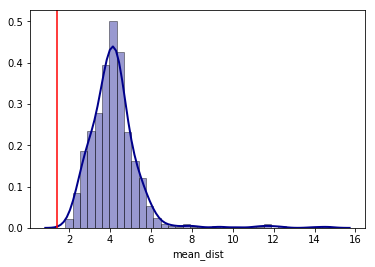

In [22]:
# mean dist to kth nn
sns.distplot(
    scores['mean_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)
plt.axvline(np.mean(obs_dist), 0, 1, color='red')

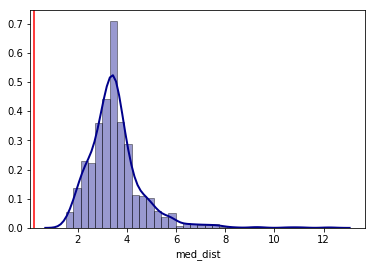

In [23]:
# median dist to kth nn
sns.distplot(
    scores['med_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)
plt.axvline(np.median(obs_dist), 0, 1, color='red')

In [24]:
print("CMPs")
print("--------------")
print("Mean dist:", sum(scores.mean_dist < np.mean(obs_dist)) / n_sim )
print("Median dist:", sum(scores.med_dist < np.median(obs_dist)) / n_sim )

CMPs
--------------
Mean dist: 0.0
Median dist: 0.0


In [25]:
# TODO: update this function to handle a mixture kde
plot_kde(
    data=pop_kde_data[:, 1:4], 
    user_data=pd.concat([a_star_unique, b_star_unique]),
    uid=user
)

### Alernative score functions

In [26]:
# inv number of visits at each location in the population
POP_LOC_WTS = pd.DataFrame(1 / pop_deduped.groupby('location_id')['event_id'].count())

def calc_location_similarity(mpp, pop_wts=POP_LOC_WTS):
    # get counts at each loc for the mpp of interest & join to pop weights
    mpp_cts = mpp.groupby(['location_id', 'm'])['uid'].count().unstack().fillna(0)
    mpp_cts = mpp_cts.join(pop_wts)

    # compute the summand & then the score
    mpp_cts['delta'] = mpp_cts.apply(
        lambda row: row['event_id']*np.log(row['a']+1)*np.log(row['b']+1), 
        axis=1
    )
    
    return mpp_cts['delta'].sum() # / np.min(mpp_star.groupby(['m'])['location_id'].nunique())


calc_location_similarity(mpp_star)


0.21162219733629684

# Population Experiment

In [27]:
def calc_cmp(mpp, pop_kde_data, userA, userB=None, n_sim=10, k=1):
    
    if not userB:  # doing it for the same source
        userB = userA
        criteria = None
        
    # get the sample space
    criteria_A = (mpp['m'] == 'a') & (mpp['uid'] == userA)
    criteria_B = (mpp['m'] == 'b') & (mpp['uid'] == userB)
    indiv_data, indiv_kde_data = get_individual_component(
        mpp, user, criteria=(criteria_A | criteria_B), prnt=False
    )
    indiv_data.head()

    # SET MPP OF INTEREST & ITS SUBPROCESSES
    a_star = mpp.loc[criteria_A]  # fix events in A^*
    b_star = mpp.loc[criteria_B] 
    a_star_unique = a_star.drop_duplicates(subset='location_id')
    b_star_unique = b_star.drop_duplicates(subset='location_id')


    # PERFORM THE SIMULATION
    sim = {}
    scores = {}
    for ell in range(n_sim):
        sim[ell] = {}
        sim[ell]['locations'] = sample_from_mixture_kde(
            pop=pop_kde_data, 
            indiv=indiv_kde_data, 
            n=n_b_star_unique, 
    #         n=n_b_star,
            user=userA
        )
        s = pd.DataFrame(sim[ell]['locations'], columns=['lon', 'lat'])
        sim[ell]['dists'] = kdnearest(a=a_star_unique, b=s, k=k)
    #     sim[ell]['dists'] = kdnearest(a=a_star, b=s, k=k)

        scores[ell] = {}
        scores[ell]['mean_dist'] = np.mean(sim[ell]['dists'])
        scores[ell]['med_dist'] = np.median(sim[ell]['dists'])
#         scores[ell]['loc_sim'] = calc_location_similarity(
#             pd.concat(
#                 [
#                     a_star, 
#                     pd.concat(
#                         [
#                             b_star_unique[['old_uid','uid','m','location_id']], 
#                             s
#                         ],
#                         axis=1
#                     )
#                 ], 
#                 ignore_index=True
#             )
#         )

    scores = pd.DataFrame.from_dict(scores, orient='index')
    obs_dist = kdnearest(a=a_star_unique, b=b_star_unique, k=k)
    # obs_dist = kdnearest(a=a_star, b=b_star, k=k) 
#     obs_loc = calc_location_similarity(
#         pd.concat([a_star, b_star], ignore_index=True)
#     )

    cmp_mean = sum(scores.mean_dist < np.mean(obs_dist)) / n_sim
    cmp_median = sum(scores.med_dist < np.mean(obs_dist)) / n_sim
#     cmp_loc = sum(scores.loc_sim > obs_loc) / n_sim
    
    return cmp_mean, cmp_median, np.mean(obs_dist), np.median(obs_dist)


In [28]:
# # PARAMETERS
# n_sim = 1000
# k = 1  # which nearest neighbor to use in distance computation
# rslt = []

# for u1 in mpp['uid'].unique():
#     print('A - USER {}'.format(u1))
#     for u2 in mpp['uid'].unique():
#         print('   B - USER {}'.format(u2))
#         cmp_mean, cmp_med, obs_mn, obs_med = calc_cmp(
#             mpp, pop_kde_data, userA=u1, userB=u2, n_sim=n_sim, k=k
#         )
#         rslt.append(
#             {
#                 "a": u1,
#                 "b": u2,
#                 "obs_mean": obs_mn,
#                 "obs_med": obs_med,
#                 "cmp_mean": cmp_mean,
#                 "cmp_med": cmp_med,
#             }
#         )
# out = pd.DataFrame.from_dict(rslt)
# out.to_csv(os.path.join(directory, "cmp_visits_month0a_month1b_n20.csv"), index=False)

In [29]:
out = pd.read_csv(os.path.join(directory, "cmp_visits_month0a_month1b_n20.csv"))
out.head()

,a,b,cmp_mean,cmp_med,obs_mean,obs_med
0,1,1,0.000,0.001,1.418317,0.213054
1,1,2,0.975,0.991,15.228736,17.597381
2,1,3,0.999,0.995,21.850145,23.518852
3,1,4,1.000,1.000,17.873691,13.960645
4,1,5,0.306,0.429,5.113124,5.249065


In [30]:
same_src = out.loc[out.a == out.b]
diff_src = out.loc[out.a != out.b]

In [31]:
same_src

,a,b,cmp_mean,cmp_med,obs_mean,obs_med
0,1,1,0.000,0.001,1.418317,0.213054
224,2,2,0.007,0.264,0.095793,0.018493
448,3,3,0.153,0.698,1.132664,0.782652
672,4,4,0.944,0.946,2.778921,0.533464


In [32]:
diff_src.describe()

,a,b,cmp_mean,cmp_med,obs_mean,obs_med
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,2.011940,111.840299,0.926399,0.939215,11.990317,11.640002
std,0.829126,64.506496,0.193960,0.143985,8.390959,8.341496
min,1.000000,1.000000,0.000000,0.003000,1.079688,0.542866
25%,1.000000,56.000000,0.978000,0.959000,5.069549,4.968294
50%,2.000000,112.000000,1.000000,1.000000,10.017062,9.908024
75%,3.000000,167.750000,1.000000,1.000000,16.983304,15.744500
max,4.000000,223.000000,1.000000,1.000000,47.477089,45.771240


In [33]:
mpp_star = mpp.loc[mpp['uid'] == 4]
mpp_star_unique = mpp_star.drop_duplicates(subset=['location_id', 'm'])

plot_kde(
    data=pop_kde_data[:, 1:4], 
    user_data=mpp_star_unique,
    uid=4
)

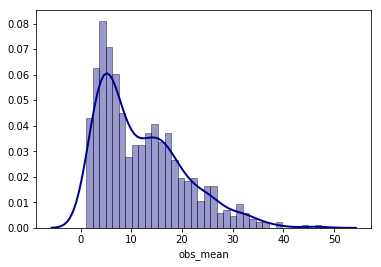

In [34]:
sns.distplot(
    diff_src['obs_mean'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)

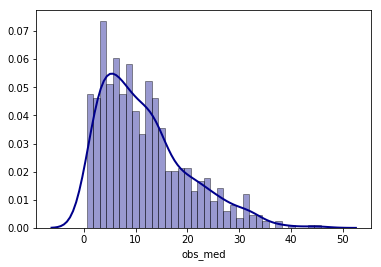

In [35]:
sns.distplot(
    diff_src['obs_med'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)